# Run the speciation model with fastscape

In [1]:
import numpy as np
import pandas as pd
import xsimlab as xs
import matplotlib.pyplot as plt

from fastscape.models import basic_model

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from paraspec.fastscape_ext import IR12Speciation, DD03Speciation
from paraspec.fastscape_ext import FastscapeElevationTrait, FastscapePrecipitationTrait
from paraspec.fastscape_ext import CompoundEnvironment, ElevationEnvField, PrecipitationField
from paraspec.fastscape_ext import RandomSeedFederation
from orographic_precipitation.fastscape_ext import OrographicPrecipitation, OrographicDrainageDischarge

## Speciation without competition in an evolving landscape

In [2]:
model = basic_model.update_processes({
    'life': IR12Speciation,
    'trait_elev':FastscapeElevationTrait,
    'trait_prep':FastscapePrecipitationTrait,
    'life_env': CompoundEnvironment,
    'elevation':ElevationEnvField,
    'precip': PrecipitationField,
    'random': RandomSeedFederation,
    'precipitation': OrographicPrecipitation,
    'drainage': OrographicDrainageDischarge
})

model

<xsimlab.Model (24 processes, 41 inputs)>
grid
    shape                  [in] ('shape_yx',) nb. of grid nodes in ...
    length                 [in] ('shape_yx',) total grid length in ...
boundary
    status                 [in] () or ('border',) node status at bo...
fs_context
uplift
    rate                   [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                   [in] random seed
surf2erode
diffusion
    diffusivity            [in] () or ('y', 'x') diffusivity (trans...
init_erosion
flow
precipitation
    lapse_rate             [in] environmental lapse rate
    lapse_rate_m           [in] moist adiabatic lapse rate
    ref_density            [in] reference saturation water vapor de...
    latitude               [in] latitude
    precip_base            [in] background, non-orographic precipit...
    rainfall_frequency  [inout] daily rainfall frequency
    wind_speed             [in] wind speed
    wind_dir               [in] wind direction (azimuth)
  

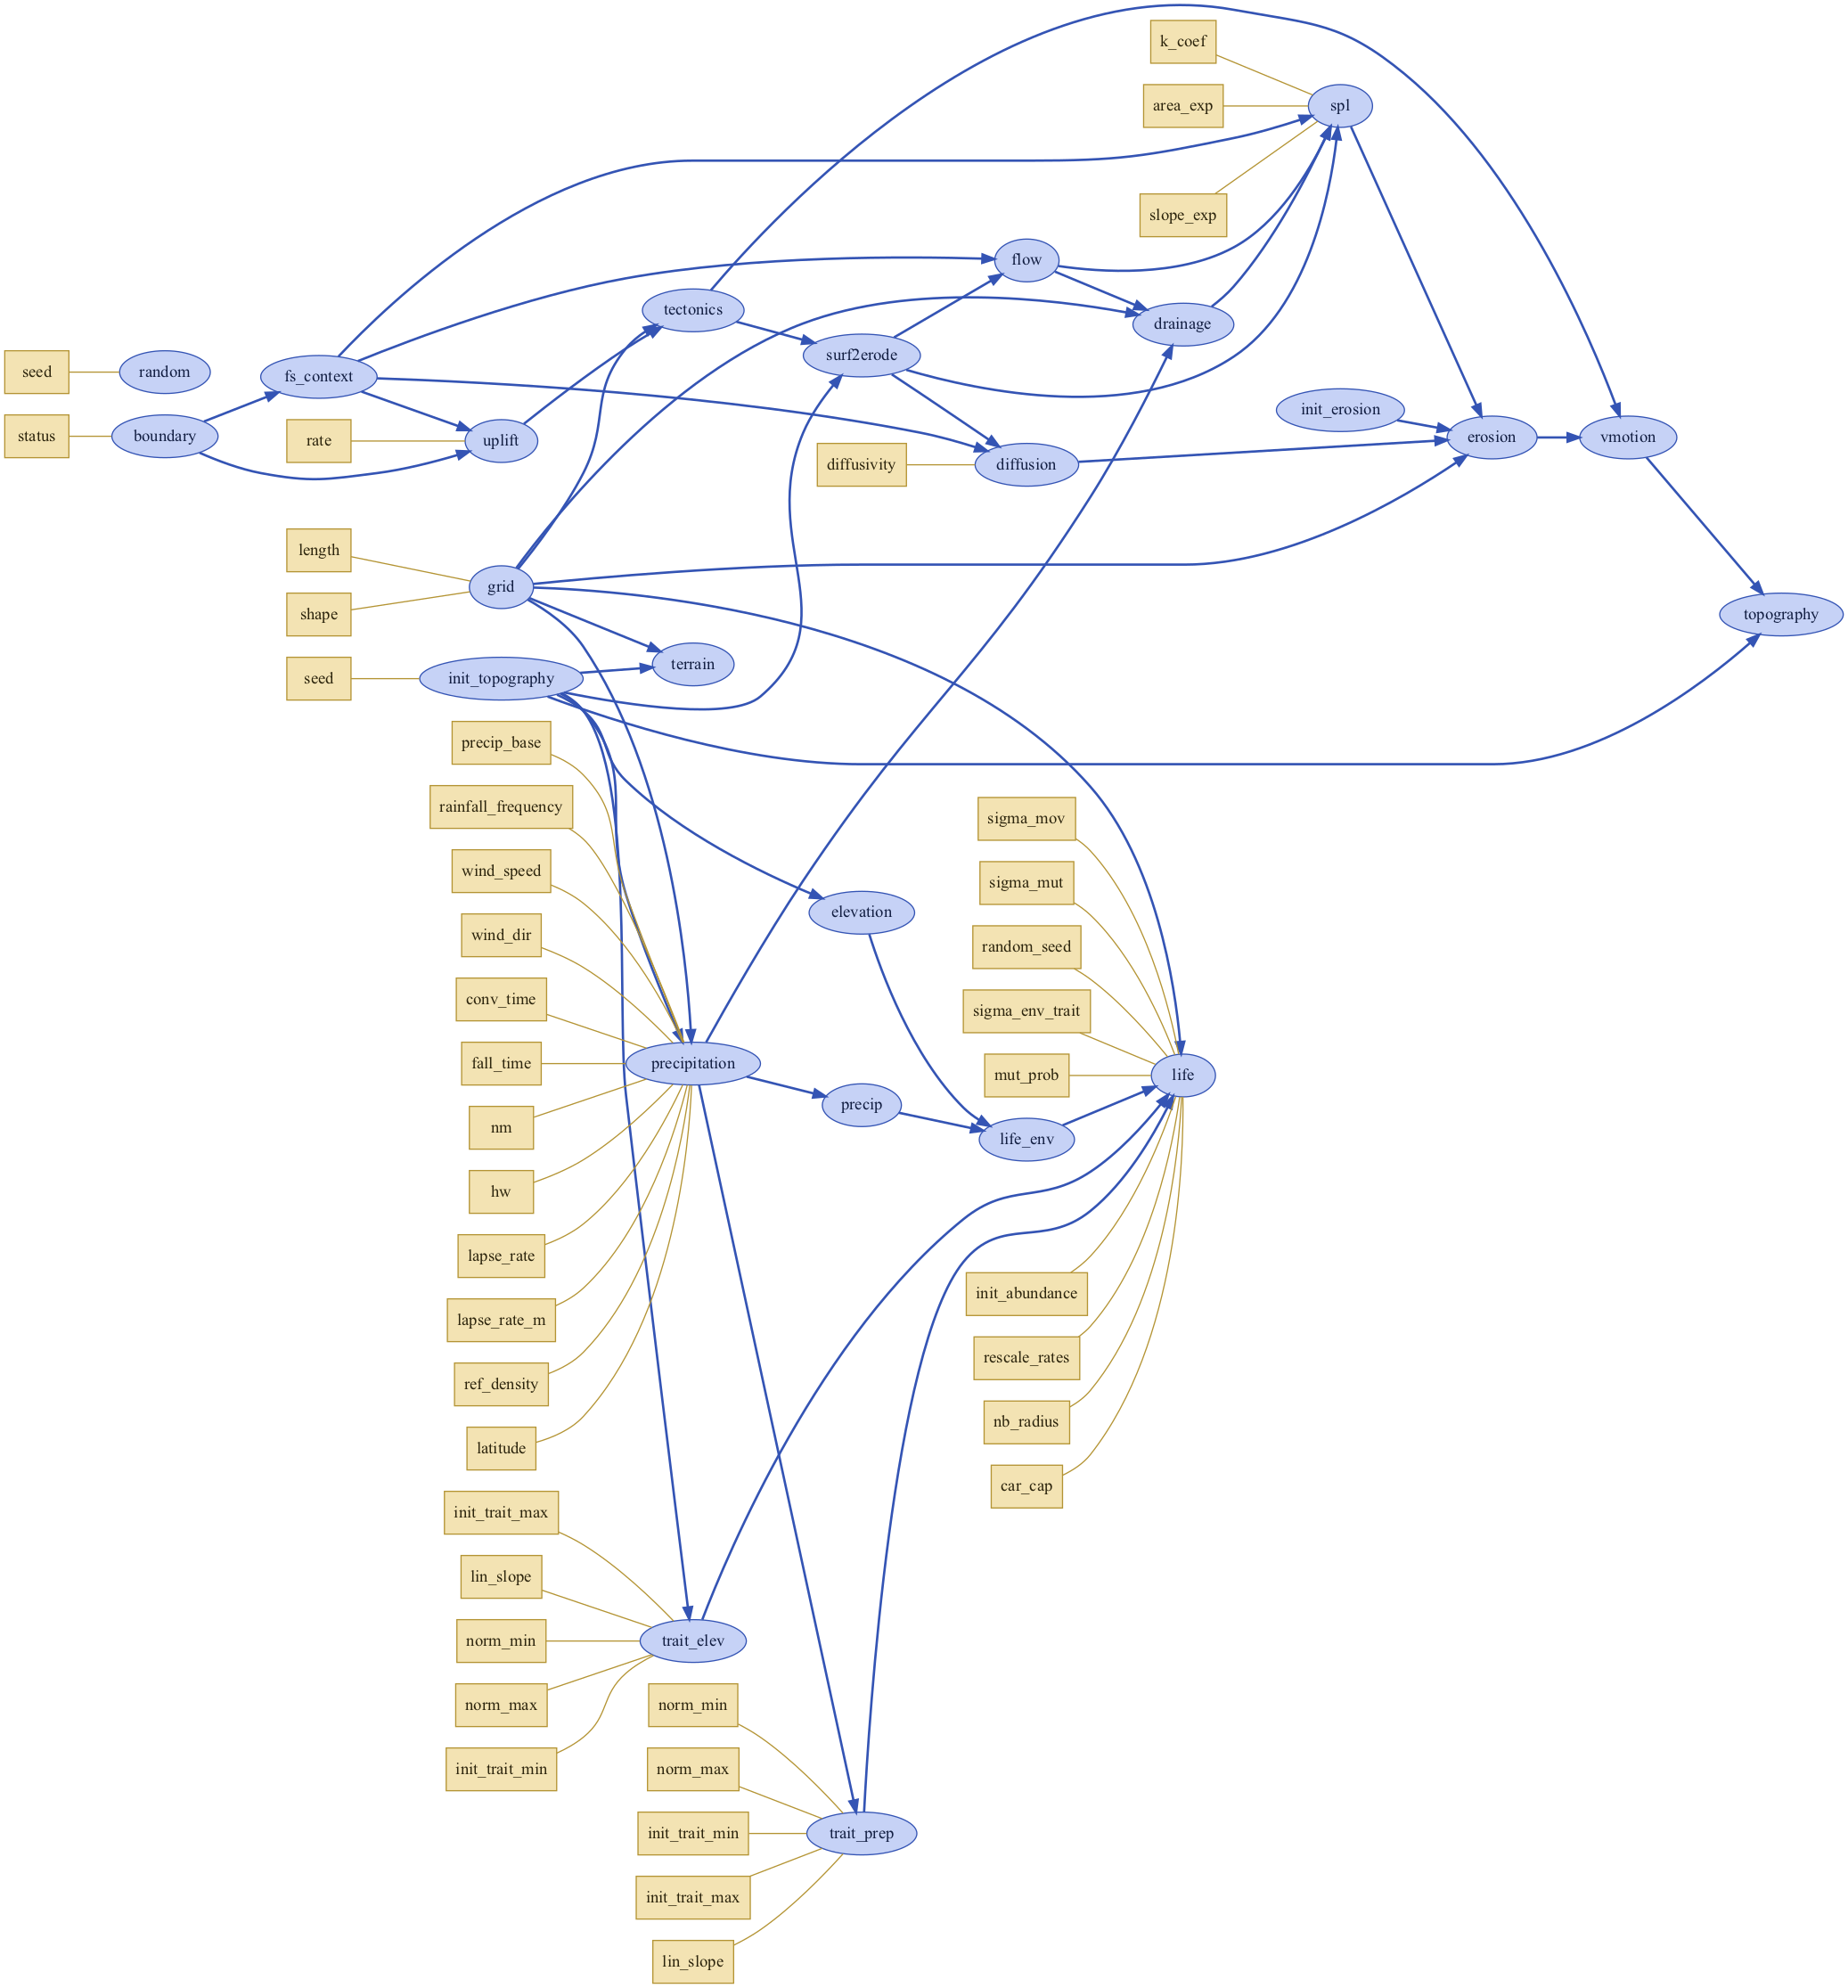

In [3]:
model.visualize(show_inputs=True)

In [4]:
random_seed = 1234
uplift_rate = 5e-3
hmax = 3500
time = np.linspace(0., 1e6, 1001)
in_ds = xs.create_setup(
    model=model,
    clocks={
        'time': time,
        'out': time[::10]
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 201], 
        'grid__length': [1e5, 2e5], 
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': uplift_rate,
        'spl__k_coef': (uplift_rate/hmax)*50,
        'spl__area_exp': 0.4,
        'spl__slope_exp': 1,
        'diffusion__diffusivity': 3e-2,
        'init_topography__seed': random_seed,
        'random':{'seed': random_seed},
        'precipitation':{
            'rainfall_frequency':0.1,
            'latitude': 10, 
            'precip_base': 5,         
            'wind_speed': 10,          
            'wind_dir': 360,            
        },
        'trait_elev': {
            'init_trait_min':0.5,
            'init_trait_max':0.5,
            'lin_slope':0.95,
            'norm_min':0,
            'norm_max':hmax,
        },
        'trait_prep': {
            'init_trait_min':0.5,
            'init_trait_max':0.5,
            'lin_slope':0.95,
            'norm_min':0,
            'norm_max':7,
        },
        'life': {
            'init_abundance': 100,
            'nb_radius': 2e4,
            'car_cap': 25,
            'sigma_mov': 1000.,
            'mut_prob': 1.0,
            'sigma_mut': 0.05, 
            'sigma_env_trait': 0.5,
            'random_seed':random_seed
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'precipitation__precip_rate':'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__traits': 'out',
        'life__taxon_id': 'out',
        'life__ancestor_id': 'out'
    }
)

In [5]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=model)

             0% | initialize 

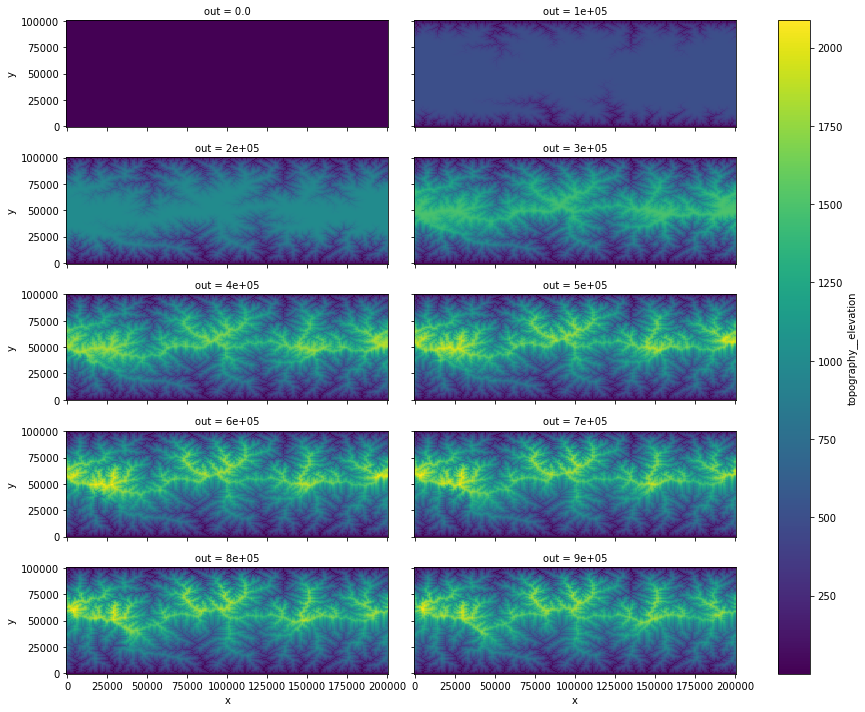

In [6]:
time_sel = np.arange(0, 1e6, 1e5)
elev_max = out_ds.topography__elevation.max()
out_ds.sel(out=time_sel).topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10))

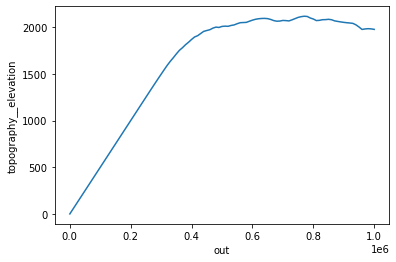

In [7]:
out_ds.topography__elevation.max(('x', 'y')).plot()

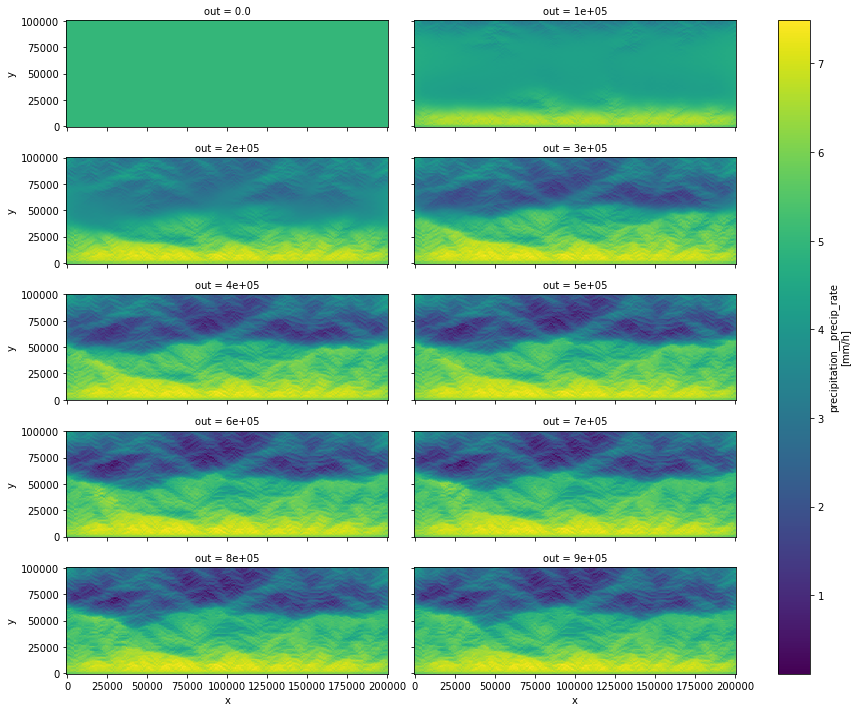

In [8]:
out_ds.sel(out=time_sel).precipitation__precip_rate.plot(col='out', col_wrap=2, figsize=(13, 10))

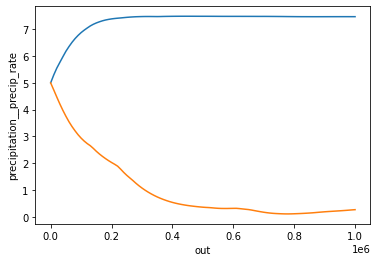

In [9]:
out_ds.precipitation__precip_rate.max(('x', 'y')).plot()
out_ds.precipitation__precip_rate.min(('x', 'y')).plot()

In [10]:
individuals_data = {}
#reshape trait data
for i in range(out_ds.life__traits.shape[2]):
    individuals_data['life__'+str(out_ds.trait[i].values.astype(str))] = out_ds.life__traits[:,:,i]
out_ds=out_ds.assign(individuals_data)

In [11]:
df = (
    out_ds
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds.dims if d not in ('out', 'ind')])
    .drop_vars(in_ds, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'ind'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .dropna()
    .reset_index()
)

df

,out,ind,ancestor_id,taxon_id,x,y,trait_prep,trait_elev
0,0.0,0,0.0,1.0,195339.953340,29784.009062,0.500000,0.500000
1,0.0,1,0.0,1.0,76039.147004,61916.101637,0.500000,0.500000
2,0.0,2,0.0,1.0,184649.246753,30175.742962,0.500000,0.500000
3,0.0,3,0.0,1.0,52338.484773,17484.645113,0.500000,0.500000
4,0.0,4,0.0,1.0,63819.411683,49550.519522,0.500000,0.500000
...,...,...,...,...,...,...,...,...
48222,1000000.0,505,13130.0,13325.0,16217.395657,21303.282676,0.598123,0.284672
48223,1000000.0,506,13277.0,13418.0,16714.451526,28616.897602,0.762682,0.131456
48224,1000000.0,507,13279.0,13420.0,13563.311263,12606.345533,0.836841,0.232166
48225,1000000.0,508,13279.0,13420.0,11938.761714,9101.317747,0.876445,0.346251


## Plot population

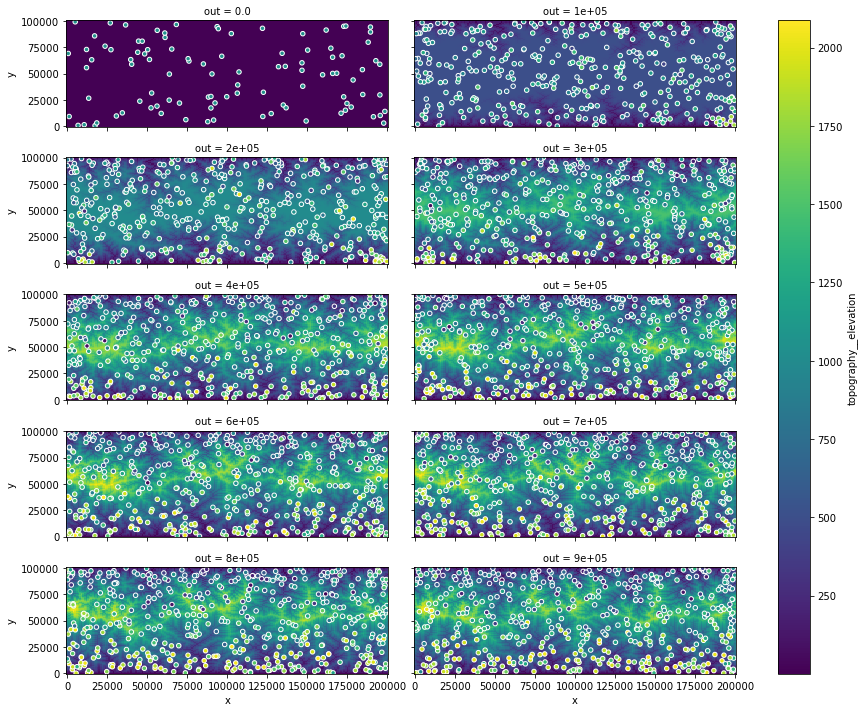

In [13]:
fg = (out_ds
      .sel(out=time_sel)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), time_sel):
    pop = df[df.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait_prep, vmin=0, vmax=1, s=20, edgecolor='w')

Text(0.5, 0, 'Time [years]')

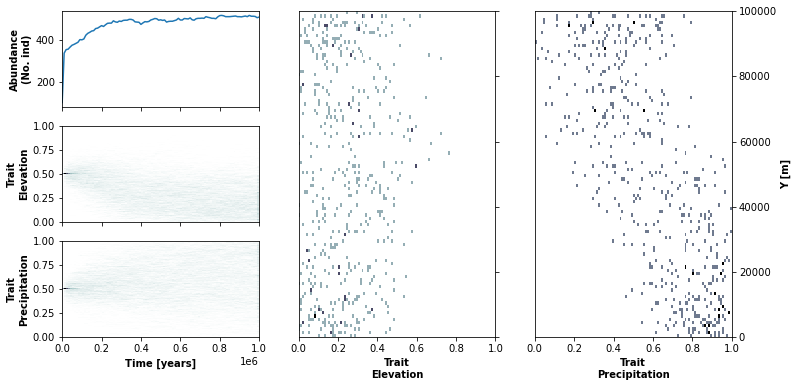

In [14]:
fig2, axs2 = plt.subplots(3, 3, sharex="col", figsize=(12, 6))
gs2 = axs2[1, 1].get_gridspec()
for ax in axs2[0:, 1:].flatten():
    ax.remove()
axbig0 = fig2.add_subplot(gs2[0:, -2])
axbig1 = fig2.add_subplot(gs2[0:, -1])
axs2[0,0].plot(df.groupby('out').size())
h,xedge,yedge,_=axs2[1,0].hist2d(x=df['out'], y=df['trait_elev'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axs2[2,0].hist2d(x=df['out'], y=df['trait_prep'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig0.hist2d(x=df['trait_elev'].loc[df['out']==max(df['out'])], 
                             y=df['y'].loc[df['out']==max(df['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig1.hist2d(x=df['trait_prep'].loc[df['out']==max(df['out'])], 
                             y=df['y'].loc[df['out']==max(df['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
axbig0.yaxis.set_tick_params(labelleft=False)
axbig1.yaxis.set_label_position("right")
axbig0.yaxis.tick_right()
axbig1.yaxis.tick_right()
axbig0.set_xlabel('Trait\nElevation', weight='bold')
axbig1.set_xlabel('Trait\nPrecipitation', weight='bold')
axbig1.set_ylabel('Y [m]', weight='bold')
axs2[0,0].set_ylabel('Abundance\n(No. ind)', weight='bold')
axs2[1,0].set_ylabel('Trait\nElevation', weight='bold')
axs2[2,0].set_ylabel('Trait\nPrecipitation', weight='bold')
axs2[2,0].set_xlabel('Time [years]', weight='bold')

## Speciation with competition in an evolving landscape

In [15]:
with model.update_processes({'life': DD03Speciation}), xs.monitoring.ProgressBar():
    out_ds2 = in_ds.xsimlab.update_vars(input_vars={'life': {
            'init_abundance': 100,
            'birth_rate': 1.0,
            'movement_rate': 5.,
            'car_cap_max': 500.,
            'mut_prob': 1.0,
            'sigma_mut': 0.05,
            'sigma_mov': 1000.,
            'sigma_env_trait': 0.5,
            'sigma_comp_trait': 0.5,
            'sigma_comp_dist': 0.5,
            'random_seed': random_seed
        }
    }   
    ).xsimlab.run(check_dims='transpose')

             0% | initialize 

In [16]:
individuals_data2 = {}
for i in range(out_ds2.life__traits.shape[2]):
    individuals_data2['life__'+str(out_ds2.trait[i].values.astype(str))] = out_ds2.life__traits[:,:,i]
out_ds2=out_ds2.assign(individuals_data2)

In [17]:
df2 = (
    out_ds2
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds.dims if d not in ('out', 'ind')])
    .drop_vars(in_ds, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'ind'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .dropna()
    .reset_index()
)

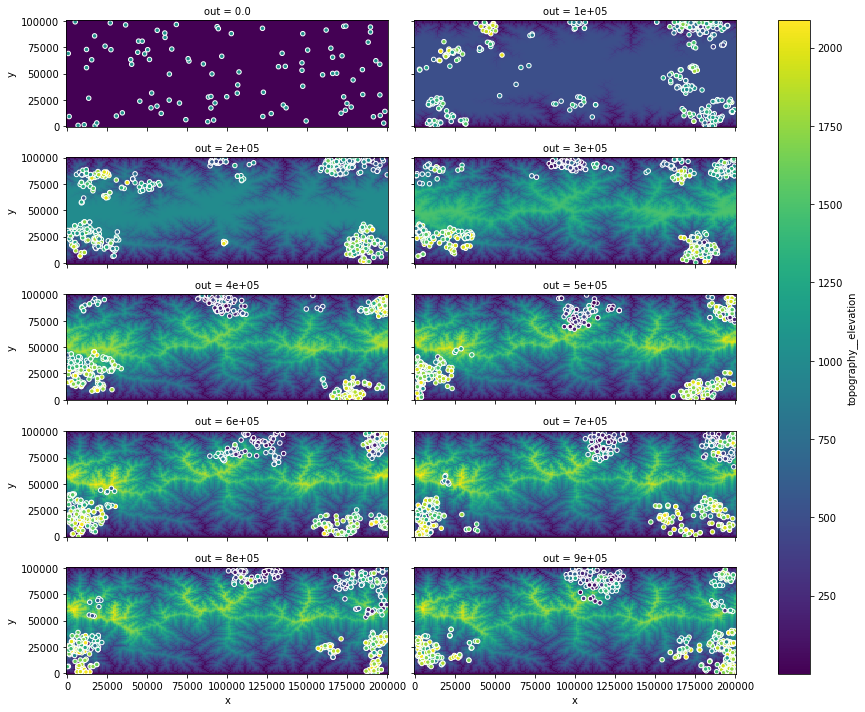

In [18]:
fg = (out_ds2
      .sel(out=time_sel)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), time_sel):
    pop = df2[df2.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait_prep, vmin=0, vmax=1, s=20, edgecolor='w')

Text(0.5, 0, 'Time [years]')

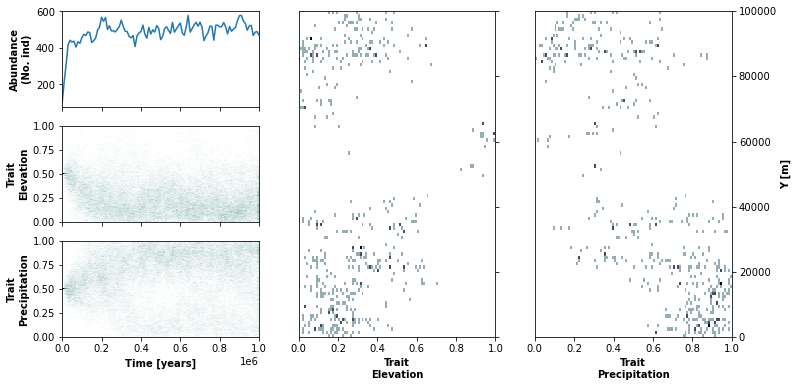

In [19]:
fig5, axs5 = plt.subplots(3, 3, sharex="col", figsize=(12, 6))
gs5 = axs5[1, 1].get_gridspec()
for ax in axs5[0:, 1:].flatten():
    ax.remove()
ax5big0 = fig5.add_subplot(gs5[0:, -2])
ax5big1 = fig5.add_subplot(gs5[0:, -1])
axs5[0,0].plot(df2.groupby('out').size())
h,xedge,yedge,_=axs5[1,0].hist2d(x=df2['out'], y=df2['trait_elev'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axs5[2,0].hist2d(x=df2['out'], y=df2['trait_prep'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=ax5big0.hist2d(x=df2['trait_elev'].loc[df2['out']==max(df2['out'])], 
                             y=df2['y'].loc[df2['out']==max(df2['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=ax5big1.hist2d(x=df2['trait_prep'].loc[df2['out']==max(df2['out'])], 
                             y=df2['y'].loc[df2['out']==max(df2['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
ax5big0.yaxis.set_tick_params(labelleft=False)
ax5big1.yaxis.set_label_position("right")
ax5big0.yaxis.tick_right()
ax5big1.yaxis.tick_right()
ax5big0.set_xlabel('Trait\nElevation', weight='bold')
ax5big1.set_xlabel('Trait\nPrecipitation', weight='bold')
ax5big1.set_ylabel('Y [m]', weight='bold')
axs5[0,0].set_ylabel('Abundance\n(No. ind)', weight='bold')
axs5[1,0].set_ylabel('Trait\nElevation', weight='bold')
axs5[2,0].set_ylabel('Trait\nPrecipitation', weight='bold')
axs5[2,0].set_xlabel('Time [years]', weight='bold')